# Air quality vs motorway traffic

Let's look at relationship between PM2.5 and traffic flow. Here:
- indoor air quality data are real and unmasked;
- traffic data and outdoor air quality data are masked, and the location "1b14" is undisclosed.

The masking method used preserves correlations between data sets, but does not preserve absolute magnitudes.

In [1]:
from lib import airqual_read
from lib import constants
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

location = "1b14"

The traffic data that we have is 1-hourly aggregated data.

To match this, we'll read in the air quality data, and then downsample it to a 1-hourly average (non-overlapping windows).

In [2]:
# Several air quality sensors are placed at this location.
# We retrieve a list of dataframes.
df_list = airqual_read.hourly_airqual(location)

# Let's pick out the second sensor at this location
df = df_list[1]

# Read in the traffic flow data for this location and append to air qual dataframe
traffic_df = pd.read_csv(constants.TRAFFIC_PATH / (location + "_traffic.csv"),index_col=0)
df = pd.concat([df,traffic_df],axis=1)

# There are two motorways near this location. We'll aggregate the traffic flows.
df["M_count"] = df["M0_count"] + df["M1_count"]

At this point, our dataframe is full of various readings of temperature, humidity, noise, CO2, particulate matter, etc.

In [3]:
print(df)

          TEMP        HUM       BATT      LIGHT    NOISE_A      PRESS  \
0    16.264059  78.628954  99.928870   0.000000  35.952594  99.764686   
1    16.346485  79.248243  99.903766   0.000000  35.865021  99.771841   
2    16.500750  80.312111  99.925000   0.000000  34.076295  99.404556   
3    16.421972  80.741444  99.916667   0.000000  34.125278  99.400889   
4    16.395894  80.813212  99.932961   0.000000  34.196369  99.416229   
..         ...        ...        ...        ...        ...        ...   
163  15.943917  76.093222  99.961111   0.000000  29.808917  99.469083   
164  15.865487  76.350251  99.944290   0.000000  29.331838  99.461393   
165  15.912694  77.273917  99.947222  21.419444  31.211778  99.448139   
166  16.070724  78.309916  99.935933   5.880223  33.647437  99.437437   
167  16.189038  77.753180  99.907950   0.000000  36.959079  99.749289   

     CCS811_VOCS  CCS811_ECO2    SCD30_CO2  SCD30_TEMP  SCD30_HUM      PM_1  \
0    1327.418410  2039.280335  1875.799163  

We'll approach this naively and try and see which variables correlate strongly with each other. Doing this shows that:
- particulate matter (PM_1, P_25, PM_10) shows reasonably hot colours against motorway traffic in a correlation heat map;
- of all indoor environmental quality variables, PM_25 (PM 2.5) and PM_10 have the strongest correlation with motorway traffic;
- the correlation coefficient is weak/moderate with a correlation of about 0.4.

<AxesSubplot: >

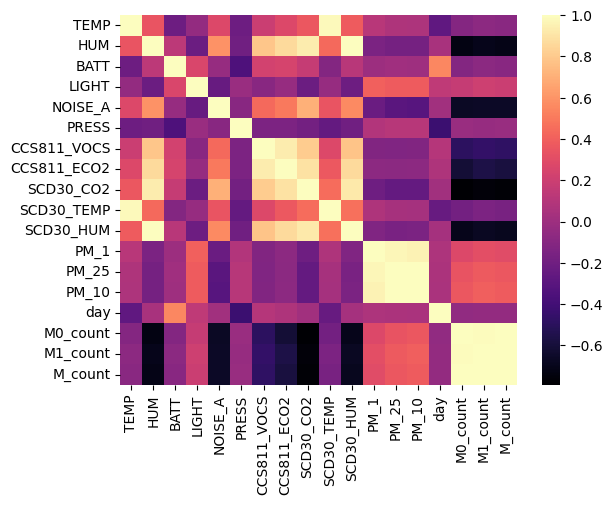

In [4]:
corr = df.corr()
sns.heatmap(corr, cmap="magma",annot=False)

In [5]:
print(corr.M_count)

TEMP          -0.091127
HUM           -0.720241
BATT          -0.098234
LIGHT          0.190017
NOISE_A       -0.664586
PRESS         -0.027323
CCS811_VOCS   -0.479208
CCS811_ECO2   -0.587075
SCD30_CO2     -0.775458
SCD30_TEMP    -0.166123
SCD30_HUM     -0.690713
PM_1           0.295394
PM_25          0.360571
PM_10          0.380991
day           -0.048439
M0_count       0.996021
M1_count       0.997297
M_count        1.000000
Name: M_count, dtype: float64


Let's plot PM 2.5 (because it's worse than PM 10 for your health) and motorway traffic as time series on the same graph:

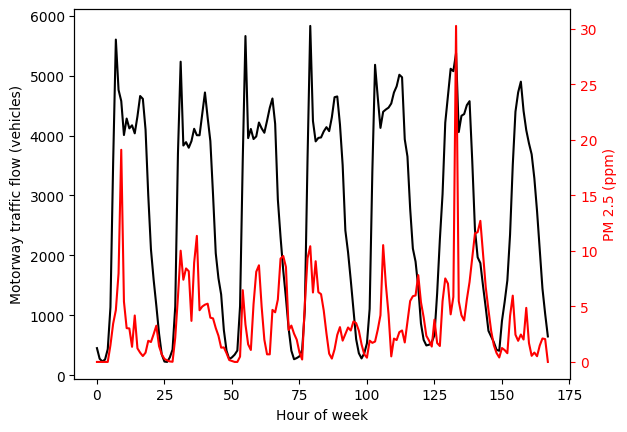

In [6]:
# Let's plot the time series
fig,ax = plt.subplots()
df.plot(y="M_count",ax=ax,style="k-")
ax.set_xlabel("Hour of week")
ax.set_ylabel("Motorway traffic flow (vehicles)")
ax1=ax.twinx()
df.plot(y="PM_25",ax=ax1, style="r-")
ax1.set_ylabel("PM 2.5 (ppm)")
ax1.yaxis.label.set_color("red")
ax1.tick_params(axis='y',colors="red")
ax.legend().remove()
ax1.legend().remove()

And scatter PM 2.5 against motorway traffic flow to show the correlation:

<AxesSubplot: xlabel='Motorway traffic flow (vehicles)', ylabel='PM 2.5 (ppm)'>

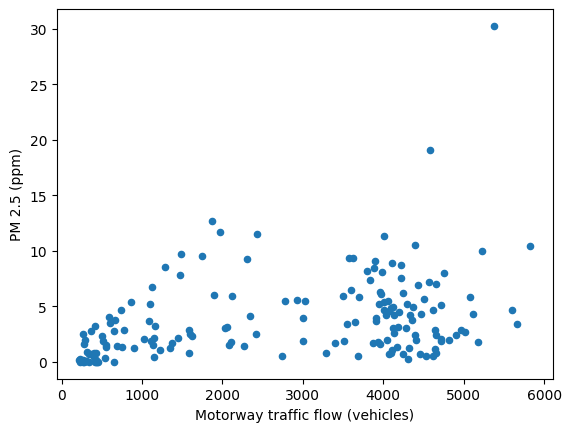

In [7]:
df.plot.scatter(x="M_count",y="PM_25", ylabel="PM 2.5 (ppm)",xlabel="Motorway traffic flow (vehicles)")

Finally, calculate the average PM 2.5 levels and compare them against WHO guidelines.

In [8]:
meanval = df["PM_25"].mean() * 1000
print(f"Average PM 2.5 is {np.rint(meanval)} ug/m3. WHO guidelines say aim for annual average of 5 ug/m3")

Average PM 2.5 is 3879.0 ug/m3. WHO guidelines say aim for annual average of 5 ug/m3
